This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/dp.html).  I recommend having both windows open, side-by-side!


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
from matplotlib import cm
from pydrake.all import (
    DiagramBuilder,
    DiscreteAlgebraicRiccatiEquation,
    LeafSystem,
    LinearSystem,
    MeshcatVisualizer,
    MultilayerPerceptron,
    PerceptronActivationType,
    RandomGenerator,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    ZeroOrderHold,
)
from pydrake.examples import AcrobotPlant, PendulumGeometry, PendulumPlant

from underactuated.jupyter import running_as_notebook
from underactuated.meshcat_utils import plot_surface
from underactuated.optimizers import Adam

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Neural Fitted Value Iteration

In [3]:
# Define the double integrator
A = np.array([[0.0, 1.0], [0.0, 0.0]])
B = np.array([[0.0], [1.0]])
Q = 0.1 * np.eye(2)
R = np.eye(1)


# vectorized
def min_time_cost(x, u):
    return 1.0 - np.isclose(x, np.zeros((2, 1))).all(axis=0)


def quadratic_regulator_cost(x, u):
    return (x * (Q @ x)).sum(axis=0) + (u * (R @ u)).sum(axis=0)


def min_time_solution(x, time_step, discount_factor=1):
    # Caveat: this does not take the zero-order hold on u into account

    q = x[0, :]
    qdot = x[1, :]
    # mask indicates that we are in the regime where u = +1.
    mask = ((qdot < 0) & (2 * q <= (qdot**2))) | (
        (qdot >= 0) & (2 * q < -(qdot**2))
    )
    T = np.empty(q.size)
    T[mask] = 2 * np.sqrt(0.5 * qdot[mask] ** 2 - q[mask]) - qdot[mask]
    T[~mask] = qdot[~mask] + 2 * np.sqrt(0.5 * qdot[~mask] ** 2 + q[~mask])

    if discount_factor == 1:
        return T
    else:
        # discount in continuous time looks like e^(-t/tau), with e^(-time_step/tau) = discount_factor; or -time_step/tau = ln(discount_factor)
        tau = -time_step / np.log(discount_factor)
        # ∫₀ᵀ exp(−t/τ) dt = τ [1 − exp(-T/τ)]
        return tau * (1 - np.exp(-T / tau))


def quadratic_regulator_solution(x, time_step, discount_factor=1):
    S = DiscreteAlgebraicRiccatiEquation(
        A=np.sqrt(discount_factor) * (np.eye(2) + time_step * A),
        B=time_step * B,
        Q=time_step * Q,
        R=time_step * R / discount_factor,
    )
    return (x * (S @ x)).sum(axis=0)


def plot_and_compare(
    mlp, context, running_cost, time_step, discount_factor=1.0
):
    x1s = np.linspace(-5, 5, 31)
    x2s = np.linspace(-4, 4, 51)
    X1s, X2s = np.meshgrid(x1s, x2s)
    N = X1s.size
    X = np.vstack((X1s.flatten(), X2s.flatten()))
    J = np.zeros((1, N))

    mlp.BatchOutput(context, X, J)

    plot_surface(
        meshcat,
        "Jhat",
        X1s,
        X2s,
        J.reshape(X1s.shape),
        rgba=Rgba(0, 0, 1),
        wireframe=True,
    )

    if running_cost == min_time_cost:
        Jd = min_time_solution(X, time_step, discount_factor)
    elif running_cost == quadratic_regulator_cost:
        Jd = quadratic_regulator_solution(X, time_step, discount_factor)

    plot_surface(
        meshcat,
        "J_desired",
        X1s,
        X2s,
        Jd.reshape(X1s.shape),
        rgba=Rgba(1, 0, 0),
        wireframe=True,
    )

First, let's simply evaluate how well the network can fit the known cost-to-go functions (using supervised learning)

In [4]:
def SupervisedDemo(running_cost, time_step, discount_factor=1.0):
    x1s = np.linspace(-5, 5, 51)
    x2s = np.linspace(-4, 4, 51)
    X1s, X2s = np.meshgrid(x1s, x2s)
    N = X1s.size
    X = np.vstack((X1s.flatten(), X2s.flatten()))

    if running_cost == min_time_cost:
        Jd = min_time_solution(X, time_step, discount_factor)
    elif running_cost == quadratic_regulator_cost:
        Jd = quadratic_regulator_solution(X, time_step, discount_factor)

    Jd = Jd.reshape((1, N))

    mlp = MultilayerPerceptron(
        [2, 64, 64, 1] if running_cost == min_time_cost else [2, 16, 16, 1],
        [
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kIdentity,
        ],
    )
    context = mlp.CreateDefaultContext()
    generator = RandomGenerator(152)
    mlp.SetRandomContext(context, generator)

    optimizer = Adam(mlp.GetMutableParameters(context))

    dloss_dparams = np.zeros(mlp.num_parameters())
    last_loss = np.inf
    for epoch in range(2000 if running_as_notebook else 2):
        loss = mlp.BackpropagationMeanSquaredError(
            context, X, Jd, dloss_dparams
        )
        if epoch % 20 == 0:
            clear_output(wait=True)
            print(f"loss = {loss}")
        if np.linalg.norm(last_loss - loss) < 1e-6:
            break
        last_loss = loss
        optimizer.step(loss, dloss_dparams)

    plot_and_compare(mlp, context, running_cost, time_step, discount_factor)


meshcat.Delete()
SupervisedDemo(min_time_cost, 0.1, 0.98)
# SupervisedDemo(quadratic_regulator_cost, 0.1)

loss = 0.0017914846092128172


## Discrete time, continuous state, discrete action

This is the standard "fitted value iteration" algorithm with a multilayer perceptron (MLP) as the function approximator, and a single step of gradient descent performed on each iteration.

In [9]:
def FittedValueIteration(running_cost, time_step, discount_factor=0.9):
    x1s = np.linspace(-5, 5, 31)
    x2s = np.linspace(-4, 4, 31)
    us = np.linspace(-1, 1, 9)
    Us, X1s, X2s = np.meshgrid(us, x1s, x2s, indexing="ij")
    XwithU = np.vstack((X1s.flatten(), X2s.flatten()))
    UwithX = Us.flatten().reshape(1, -1)
    Nx = x1s.size * x2s.size
    X = XwithU[:, :Nx]
    N = X1s.size

    Xnext = XwithU + time_step * (A @ XwithU + B @ UwithX)
    Cost = time_step * running_cost(XwithU, UwithX)
    Jnext = np.zeros((1, N))
    Jd = np.zeros((1, Nx))

    mlp = MultilayerPerceptron(
        [2, 100, 100, 1] if running_cost == min_time_cost else [2, 16, 16, 1],
        [
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kIdentity,
        ],
    )
    context = mlp.CreateDefaultContext()
    generator = RandomGenerator(123)
    mlp.SetRandomContext(context, generator)

    optimizer = Adam(mlp.GetMutableParameters(context))

    plot_and_compare(mlp, context, running_cost, time_step, discount_factor)
    dloss_dparams = np.zeros(mlp.num_parameters())
    last_loss = np.inf
    for epoch in range(50 if running_as_notebook else 2):
        mlp.BatchOutput(context, Xnext, Jnext)
        Jd[:] = np.min(
            (Cost + discount_factor * Jnext).reshape(us.size, Nx), axis=0
        )
        for i in range(100 if running_as_notebook else 2):
            loss = mlp.BackpropagationMeanSquaredError(
                context, X, Jd, dloss_dparams
            )
            optimizer.step(loss, dloss_dparams)
        if np.linalg.norm(last_loss - loss) < 1e-8:
            break
        last_loss = loss
        clear_output(wait=True)
        print(f"epoch {epoch}: loss = {loss}")
        if epoch % 10 == 0:
            plot_and_compare(
                mlp, context, running_cost, time_step, discount_factor
            )

    plot_and_compare(mlp, context, running_cost, time_step, discount_factor)


FittedValueIteration(min_time_cost, 0.1, discount_factor=0.95)

# FittedValueIteration(quadratic_regulator_cost, 0.1, discount_factor=0.9)

epoch 49: loss = 2.020932941611841e-05


## Continuous-time, state, and actions

I've written this to take an arbitrary system as the input.  It requires that the system has only continuous-time dynamics, and it assumes (currently without checking) that the system is control affine.

In [10]:
def ContinuousFittedValueIteration(
    plant,
    plant_context,
    value_mlp,
    state_cost_function,
    R_diag,
    state_samples,
    time_step=0.01,
    discount_factor=1.0,
    input_port_index=0,
    lr=0.001,
    minibatch=None,
    epochs=1000,
    optim_steps_per_epoch=25,
    input_limits=None,
):
    input_port = plant.get_input_port(input_port_index)
    num_states = plant.num_continuous_states()
    num_inputs = input_port.size()
    N = state_samples.shape[1]

    # assert plant.ValidateContext(plant_context)  # TODO(russt): bind this
    assert plant_context.has_only_continuous_state()
    assert value_mlp.get_input_port().size() == num_states
    assert value_mlp.layers()[-1] == 1
    assert R_diag.shape == (num_inputs,)
    assert state_samples.shape[0] == num_states
    assert time_step > 0.0
    assert discount_factor > 0.0 and discount_factor <= 1.0
    if input_limits != None:
        assert (
            num_inputs == 1
        ), "Input limits are only supported for scalar inputs (for now)"
        assert len(input_limits) == 2

    mlp_context = value_mlp.CreateDefaultContext()
    generator = RandomGenerator(123)
    value_mlp.SetRandomContext(mlp_context, generator)

    state_cost = state_cost_function(state_samples)
    state_dynamics_x = np.empty((N, num_states))
    dstate_dynamics_du = [np.empty((num_states, N))] * num_inputs
    Rinv = 1 / R_diag

    state = plant_context.get_mutable_continuous_state_vector()

    # Precompute dynamics and cost (TODO: parallelize this).
    for i in range(N):
        u = np.zeros(num_inputs)
        input_port.FixValue(plant_context, u)
        state.SetFromVector(state_samples[:, i])
        state_dynamics_x[i] = plant.EvalTimeDerivatives(
            plant_context
        ).CopyToVector()
        for j in range(num_inputs):
            u[j] = 1
            input_port.FixValue(plant_context, u)
            dstate_dynamics_du[j][:, i] = (
                plant.EvalTimeDerivatives(plant_context).CopyToVector()
                - state_dynamics_x[i]
            )
            u[j] = 0

    optimizer = Adam(value_mlp.GetMutableParameters(mlp_context), lr=lr)

    M = minibatch if minibatch else N
    J = np.zeros((1, M))
    Jnext = np.zeros((1, M))
    Jd = np.zeros((1, M))
    dJdX = np.asfortranarray(np.zeros((num_states, M)))
    dloss_dparams = np.zeros(value_mlp.num_parameters())
    last_loss = np.inf
    for epoch in range(epochs if running_as_notebook else 2):
        if minibatch:
            batch = np.random.randint(0, N, minibatch)
        else:
            batch = range(N)
        value_mlp.BatchOutput(mlp_context, state_samples[:, batch], J, dJdX)
        Xnext = (
            state_samples[:, batch] + time_step * state_dynamics_x[batch, :].T
        )
        G = state_cost[batch]
        for i in range(num_inputs):
            ui = (
                -0.5
                * Rinv[i]
                * np.sum(dstate_dynamics_du[i][:, batch] * dJdX, 0)
            )
            if input_limits != None:
                ui = np.minimum(
                    np.maximum(ui, input_limits[0]), input_limits[1]
                )
            G += R_diag[i] * ui**2
            Xnext += time_step * dstate_dynamics_du[i][:, batch] * ui
        value_mlp.BatchOutput(mlp_context, Xnext, Jnext)
        Jd[:] = G * time_step + discount_factor * Jnext
        for i in range(optim_steps_per_epoch if running_as_notebook else 2):
            loss = value_mlp.BackpropagationMeanSquaredError(
                mlp_context, state_samples[:, batch], Jd, dloss_dparams
            )
            optimizer.step(loss, dloss_dparams)
        if not minibatch and np.linalg.norm(last_loss - loss) < 1e-8:
            break
        last_loss = loss
        if epoch % 20 == 0:
            clear_output(wait=True)
            print(f"epoch {epoch}: loss = {loss}")

    return mlp_context


class ContinuousFittedValueIterationPolicy(LeafSystem):
    def __init__(
        self,
        plant,
        value_mlp,
        value_mlp_context,
        R_diag,
        input_port_index=0,
        input_limits=None,
    ):
        LeafSystem.__init__(self)

        num_plant_states = value_mlp.get_input_port().size()
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()

        self.value_mlp = value_mlp
        self.value_mlp_context = value_mlp_context
        self.J = np.zeros((1, 1))
        self.dJdX = np.asfortranarray(np.zeros((num_plant_states, 1)))

        self.Rinv = 1 / R_diag
        self.input_limits = input_limits
        self.DeclareVectorInputPort("plant_state", num_plant_states)
        self._plant_input_port = self._plant.get_input_port(input_port_index)
        self.DeclareVectorOutputPort(
            "output", self._plant_input_port.size(), self.CalcOutput
        )

    def CalcOutput(self, context, output):
        num_inputs = self._plant_input_port.size()
        u = np.zeros(num_inputs)
        plant_state = self.get_input_port().Eval(context)

        self.value_mlp.BatchOutput(
            self.value_mlp_context,
            np.atleast_2d(plant_state).T,
            self.J,
            self.dJdX,
        )

        self._plant_context.SetContinuousState(plant_state)
        self._plant_input_port.FixValue(self._plant_context, u)
        state_dynamics_x = self._plant.EvalTimeDerivatives(
            self._plant_context
        ).CopyToVector()
        for i in range(num_inputs):
            u[i] = 1
            self._plant_input_port.FixValue(self._plant_context, u)
            dstate_dynamics_dui = (
                self._plant.EvalTimeDerivatives(
                    self._plant_context
                ).CopyToVector()
                - state_dynamics_x
            )
            ui = -0.5 * self.Rinv[i] * dstate_dynamics_dui.dot(self.dJdX)
            if self.input_limits != None:
                ui = np.minimum(
                    np.maximum(ui, self.input_limits[0]), self.input_limits[1]
                )
            output.SetAtIndex(i, ui)
            u[i] = 0

### Double Integrator

In [11]:
A = np.array([[0.0, 1.0], [0.0, 0.0]])
B = np.array([[0.0], [1.0]])
plant = LinearSystem(A, B, np.empty((0, 2)), np.empty((0, 1)))
plant_context = plant.CreateDefaultContext()

Q = np.eye(2)


def quadratic_regulator_state_cost(x):
    return (x * (Q @ x)).sum(axis=0)


R_diag = np.array([1])
R = np.eye(1)
time_step = 0.01
discount_factor = 0.9

value_mlp = MultilayerPerceptron(
    [2, 16, 16, 1],
    [
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kIdentity,
    ],
)

x1s = np.linspace(-5, 5, 31)
x2s = np.linspace(-4, 4, 31)
X1s, X2s = np.meshgrid(x1s, x2s, indexing="ij")
state_samples = np.vstack((X1s.flatten(), X2s.flatten()))
value_mlp_context = ContinuousFittedValueIteration(
    plant,
    plant_context,
    value_mlp,
    quadratic_regulator_state_cost,
    R_diag,
    state_samples,
    time_step=time_step,
    discount_factor=discount_factor,
)

meshcat.Delete()
meshcat.ResetRenderMode()
plot_and_compare(
    value_mlp,
    value_mlp_context,
    quadratic_regulator_cost,
    time_step,
    discount_factor,
)

epoch 100: loss = 1.3482075528850983e-05


### Pendulum

epoch 2980: loss = 0.7859201407990287


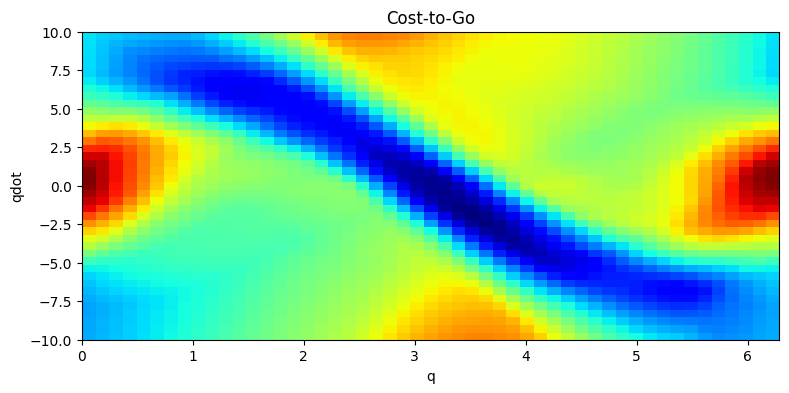

None

In [12]:
plant = PendulumPlant()
plant_context = plant.CreateDefaultContext()

Q = np.diag([10, 1])


def quadratic_regulator_state_cost(x):
    err = np.copy(x)
    err[0] -= np.pi
    return (err * (Q @ err)).sum(axis=0)


R_diag = np.array([1])
R = np.diag(R_diag)

value_mlp = MultilayerPerceptron(
    [True, False],
    [100, 100, 1],
    [
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kIdentity,
    ],
)

qs = np.linspace(0.0, 2.0 * np.pi, 51)
qdots = np.linspace(-10.0, 10.0, 41)
Qs, Qdots = np.meshgrid(qs, qdots)
state_samples = np.vstack((Qs.flatten(), Qdots.flatten()))
time_step = 0.01
discount_factor = 0.999
torque_limit = 3
value_mlp_context = ContinuousFittedValueIteration(
    plant,
    plant_context,
    value_mlp,
    quadratic_regulator_state_cost,
    R_diag,
    state_samples,
    time_step=time_step,
    discount_factor=discount_factor,
    minibatch=32,
    lr=1e-5,
    epochs=3000,
    optim_steps_per_epoch=100,
    input_limits=[-torque_limit, torque_limit],
)

J = value_mlp.BatchOutput(value_mlp_context, state_samples)
fig = plt.figure(1, figsize=(9, 4))
ax = fig.subplots()
ax.set_xlabel("q")
ax.set_ylabel("qdot")
ax.set_title("Cost-to-Go")
ax.imshow(
    J.reshape(qdots.size, qs.size),
    cmap=cm.jet,
    extent=(qs[0], qs[-1], qdots[-1], qdots[0]),
)
ax.invert_yaxis()
ax.axis("auto")
display(plt.show());

In [13]:
def simulate(value_mlp, value_mlp_context, R_diag):
    builder = DiagramBuilder()

    scene_graph = builder.AddSystem(SceneGraph())
    plant = builder.AddSystem(PendulumPlant())
    PendulumGeometry.AddToBuilder(
        builder, plant.get_state_output_port(), scene_graph
    )

    policy = builder.AddSystem(
        ContinuousFittedValueIterationPolicy(
            plant,
            value_mlp,
            value_mlp_context,
            R_diag,
            input_limits=[-torque_limit, torque_limit],
        )
    )
    builder.Connect(plant.get_state_output_port(), policy.get_input_port())

    zoh = builder.AddSystem(ZeroOrderHold(time_step, 1))
    builder.Connect(policy.get_output_port(), zoh.get_input_port())
    builder.Connect(zoh.get_output_port(), plant.get_input_port())

    meshcat.Delete()
    meshcat.Set2dRenderMode(
        X_WC=RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0, 1, 0])
    )
    vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    context.SetContinuousState([0.1, 0])
    # simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    vis.StartRecording(False)
    simulator.AdvanceTo(4)
    vis.PublishRecording()


simulate(value_mlp, value_mlp_context, R_diag)

### Acrobot

Note: I haven't quite finished this example yet!  (coming soon)

In [14]:
plant = AcrobotPlant()
plant_context = plant.CreateDefaultContext()

Q = np.diag([10, 10, 1, 1])


def quadratic_regulator_state_cost(x):
    err = np.copy(x)
    err[0] -= np.pi
    return (err * (Q @ err)).sum(axis=0)


R_diag = np.array([1])
R = np.diag(R_diag)

value_mlp = MultilayerPerceptron(
    [True, True, False, False],
    [32, 32, 1],
    [
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kIdentity,
    ],
)

q1s = np.linspace(0.0, 2.0 * np.pi, 21)
q2s = np.linspace(0.0, 2.0 * np.pi, 21)
q1dots = np.linspace(-10.0, 10.0, 11)
q2dots = np.linspace(-10.0, 10.0, 11)
Q1s, Q2s, Q1dots, Q2dots = np.meshgrid(q1s, q2s, q1dots, q2dots)
state_samples = np.vstack(
    (Q1s.flatten(), Q2s.flatten(), Q1dots.flatten(), Q2dots.flatten())
)
time_step = 0.01
discount_factor = 0.95
mlp_context = ContinuousFittedValueIteration(
    plant,
    plant_context,
    value_mlp,
    quadratic_regulator_state_cost,
    R_diag,
    state_samples,
    time_step=time_step,
    discount_factor=discount_factor,
    lr=1e-5,
    minibatch=500,
)

epoch 980: loss = 4.086267878435558


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=526ff99b-f112-4247-9b0b-c52f0f88d6ce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>